In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
path = "census-income.data"
df = pd.read_csv(path, header=None)

columns = [
    "age","class_of_worker","industry_code","occupation_code",
    "adjusted_gross_income","education","wage_per_hour",
    "enrolled_in_edu_last_week","marital_status","major_industry_code",
    "major_occupation_code","race","hispanic_origin","sex",
    "labor_union_member","reason_for_unemployment","employment_status",
    "capital_gains","capital_losses","dividends_from_stocks",
    "tax_filer_status","region_prev_residence","state_prev_residence",
    "household_family_status","household_summary","migration_msa",
    "migration_reg","migration_within_reg","lived_here_last_year",
    "migration_sunbelt","num_persons_worked_for_employer",
    "family_members_under_18","birth_country_father",
    "birth_country_mother","birth_country_self","citizenship",
    "self_employed","veteran_questionnaire","veteran_benefits",
    "weeks_worked_year","year","income"
]
df.columns = columns

df.shape

(199523, 42)

In [3]:
leakage_cols = [ "adjusted_gross_income",
    "total_person_income",
    "taxable_income_amount",
    "federal_income_tax_liability",
    "instance_weight"    
]
df = df.drop(columns=[c for c in leakage_cols if c in df.columns])

In [4]:
income_raw = df["income"].astype(str)
income_clean = (
    income_raw
    .str.replace("\u00a0", " ", regex=False)      
    .str.replace(".", "", regex=False)            
    .str.replace(r"\s+", " ", regex=True)         
    .str.strip()
)
y = np.where(
    income_clean.str.contains(r"50000\+", regex=True), 1,
    np.where(income_clean.str.contains(r"-\s*50000", regex=True), 0, np.nan)
)
print("Unique cleaned labels:", income_clean.value_counts().head(10))
print("Missing y:", int(np.isnan(y).sum()))
print("Unknown labels examples (repr):")
unknown_examples = income_clean[np.isnan(y)].head(20).tolist()
for s in unknown_examples:
    print(repr(s))

Unique cleaned labels: - 50000    187141
50000+      12382
Name: income, dtype: int64
Missing y: 0
Unknown labels examples (repr):


In [5]:
X = (df.drop(columns=["income"]).replace("?", np.nan))
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (199523, 40)
y shape: (199523,)


In [6]:
numeric_features = X.select_dtypes(include=["int64","float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns
len(numeric_features),len(categorical_features)

(13, 27)

In [7]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer,numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

model = LogisticRegression(max_iter=300, class_weight="balanced")

clf = Pipeline([
    ("preprocess", preprocess),
    ("model", model)
])

In [8]:
X_train,X_test,y_train,y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, digits=3))

C:\Users\moham\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC: 0.9389328124145528
Confusion matrix:
 [[31358  6071]
 [  273  2203]]

Report:
               precision    recall  f1-score   support

         0.0      0.991     0.838     0.908     37429
         1.0      0.266     0.890     0.410      2476

    accuracy                          0.841     39905
   macro avg      0.629     0.864     0.659     39905
weighted avg      0.946     0.841     0.877     39905



In [9]:
print("y_proba exists:", "y_proba" in globals())
print("len(y_proba):", len(y_proba))
print("positive rate in test:", y_test.mean())

y_proba exists: True
len(y_proba): 39905
positive rate in test: 0.06204736248590402


In [10]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
print("precision length", len(precision))
print("recall length:", len(recall))
print("thresholds length", len(thresholds))

precision length 26914
recall length: 26914
thresholds length 26913


In [11]:
sample_idx = [0, 50,100, 150, 200, 300]

for i in sample_idx:
    if i < len(thresholds):
        thr = thresholds[i]
        p = precision[i]
        r = recall[i]
        print(f"i={i:3d} | thr={thr:.3f} | precision={p:.3f} | recall={p:.3f}")

i=  0 | thr=0.008 | precision=0.092 | recall=0.092
i= 50 | thr=0.008 | precision=0.092 | recall=0.092
i=100 | thr=0.009 | precision=0.092 | recall=0.092
i=150 | thr=0.009 | precision=0.092 | recall=0.092
i=200 | thr=0.009 | precision=0.093 | recall=0.093
i=300 | thr=0.010 | precision=0.093 | recall=0.093


In [12]:
candidate_thresholds = [0.3, 0.5, 0.7, 0.85]
for thr in candidate_thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)

    print(f"\n=== Threshold = {thr} ===")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_thr))
    print(classification_report(y_test, y_pred_thr, digits=3))


=== Threshold = 0.3 ===
Confusion matrix:
 [[27883  9546]
 [  126  2350]]
              precision    recall  f1-score   support

         0.0      0.996     0.745     0.852     37429
         1.0      0.198     0.949     0.327      2476

    accuracy                          0.758     39905
   macro avg      0.597     0.847     0.590     39905
weighted avg      0.946     0.758     0.820     39905


=== Threshold = 0.5 ===
Confusion matrix:
 [[31358  6071]
 [  273  2203]]
              precision    recall  f1-score   support

         0.0      0.991     0.838     0.908     37429
         1.0      0.266     0.890     0.410      2476

    accuracy                          0.841     39905
   macro avg      0.629     0.864     0.659     39905
weighted avg      0.946     0.841     0.877     39905


=== Threshold = 0.7 ===
Confusion matrix:
 [[34287  3142]
 [  569  1907]]
              precision    recall  f1-score   support

         0.0      0.984     0.916     0.949     37429
         1.0

In [13]:
FINAL_THRESHOLD = 0.7

y_pred_final = (y_proba >= FINAL_THRESHOLD).astype(int)

print("FINAL_THRESHOLD =", FINAL_THRESHOLD)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final, digits=3))

FINAL_THRESHOLD = 0.7
Confusion matrix:
 [[34287  3142]
 [  569  1907]]
              precision    recall  f1-score   support

         0.0      0.984     0.916     0.949     37429
         1.0      0.378     0.770     0.507      2476

    accuracy                          0.907     39905
   macro avg      0.681     0.843     0.728     39905
weighted avg      0.946     0.907     0.921     39905



In [14]:
cat_cardinality = (
    X.select_dtypes(include=["object"])
    .nunique()
    .sort_values(ascending=False))


In [15]:
cat_cardinality

region_prev_residence        51
birth_country_self           43
birth_country_mother         43
birth_country_father         43
state_prev_residence         38
marital_status               24
major_industry_code          15
race                         10
migration_within_reg         10
migration_msa                10
migration_reg                 9
class_of_worker               9
household_family_status       8
reason_for_unemployment       8
enrolled_in_edu_last_week     7
tax_filer_status              6
dividends_from_stocks         6
labor_union_member            6
family_members_under_18       5
major_occupation_code         5
citizenship                   5
migration_sunbelt             4
wage_per_hour                 3
sex                           3
lived_here_last_year          3
veteran_questionnaire         3
hispanic_origin               2
dtype: int64

In [16]:
high_card_drop = ["region_prev_residence",
                  "birth_country_self",
                  "birth_country_mother",
                  "birth_country_father",
                  "state_prev_residence"]
X_b = X.drop(columns=[c for c in high_card_drop if c in X.columns])
print("original X shape", X.shape)
print("after drop X_b shape", X_b.shape)

original X shape (199523, 40)
after drop X_b shape (199523, 35)


In [17]:
numeric_features_b = X_b.select_dtypes(include=["int64","float64"]).columns
categorical_features_b = X_b.select_dtypes(include=["object"]).columns
print(len(numeric_features_b), len(categorical_features_b))

13 22


In [18]:
numeric_transformer_b = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_b = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_b = ColumnTransformer([
    ("num", numeric_transformer_b, numeric_features_b),
    ("cat", categorical_transformer_b, categorical_features_b)
])

model_b = LogisticRegression(
    max_iter=300,
    class_weight="balanced"
)

clf_b = Pipeline([
    ("preprocess", preprocess_b),
    ("model", model_b)
])

In [19]:
Xb_train, Xb_test, y_train, y_test = train_test_split(
    X_b, y, test_size=0.2, stratify=y, random_state=42
)

clf_b.fit(Xb_train, y_train)

y_proba_b = clf_b.predict_proba(Xb_test)[:, 1]

C:\Users\moham\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
y_pred_b = (y_proba_b >= FINAL_THRESHOLD).astype(int)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_b))
print(classification_report(y_test, y_pred_b, digits=3))

Confusion matrix:
 [[34281  3148]
 [  558  1918]]
              precision    recall  f1-score   support

         0.0      0.984     0.916     0.949     37429
         1.0      0.379     0.775     0.509      2476

    accuracy                          0.907     39905
   macro avg      0.681     0.845     0.729     39905
weighted avg      0.946     0.907     0.921     39905



In [21]:
print("X:", X.shape, "y:", y.shape, "positive rate", y.mean())

X: (199523, 40) y: (199523,) positive rate 0.06205800834991455


In [22]:
!pip -q install xgboost

In [23]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("pos:", int(pos), "neg:", int(neg), "scale_pos_weight:", scale_pos_weight)

Train size: (159618, 40) Test size: (39905, 40)
pos: 9906 neg: 149712 scale_pos_weight: 15.113264688067838


In [25]:
numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_xgb = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [26]:
xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    tree_method="hist",
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)

clf_xgb = Pipeline([
    ("preprocess", preprocess_xgb),
    ("model", xgb_model)
])

In [27]:
clf_xgb.fit(X_train, y_train)
y_proba_xgb = clf_xgb.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba_xgb))

ROC-AUC: 0.9524728100173377
PR-AUC (Average Precision): 0.6745492775950619


In [28]:
candidate_thresholds = [0.3, 0.5, 0.7, 0.85]

for thr in candidate_thresholds:
    y_pred_thr = (y_proba_xgb >= thr).astype(int)
    print(f"\n=== Threshold = {thr} ===")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_thr))
    print(classification_report(y_test, y_pred_thr, digits=3))


=== Threshold = 0.3 ===
Confusion matrix:
 [[30693  6736]
 [  164  2312]]
              precision    recall  f1-score   support

         0.0      0.995     0.820     0.899     37429
         1.0      0.256     0.934     0.401      2476

    accuracy                          0.827     39905
   macro avg      0.625     0.877     0.650     39905
weighted avg      0.949     0.827     0.868     39905


=== Threshold = 0.5 ===
Confusion matrix:
 [[33142  4287]
 [  307  2169]]
              precision    recall  f1-score   support

         0.0      0.991     0.885     0.935     37429
         1.0      0.336     0.876     0.486      2476

    accuracy                          0.885     39905
   macro avg      0.663     0.881     0.710     39905
weighted avg      0.950     0.885     0.907     39905


=== Threshold = 0.7 ===
Confusion matrix:
 [[35051  2378]
 [  562  1914]]
              precision    recall  f1-score   support

         0.0      0.984     0.936     0.960     37429
         1.0

In [29]:
import shap

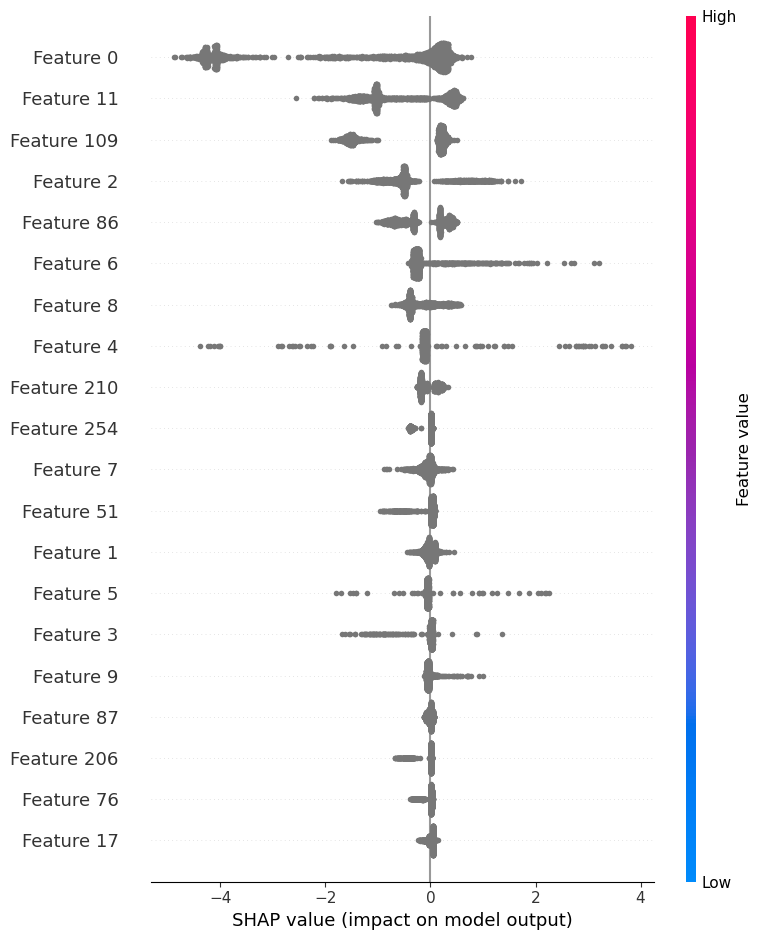

In [31]:
preprocess = clf_xgb.named_steps["preprocess"]
model = clf_xgb.named_steps["model"]
X_test_trans = preprocess.transform(X_test) 
X_small = X_test_trans[:2000]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_small)
shap.summary_plot(shap_values, X_small)